In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from psifr import fr

from cymr import cmr
from dcmr import framework
from dcmr import figures
from dcmr import task

res_dir = Path(os.environ['PEERS_RESULTS']).parent / 'incidental'
fit_dir = Path(os.environ['PEERS_FITS'])
# fig_dir = Path(os.environ['CFR_FIGURES']) / 'sim2_full'

data_file = res_dir / 'data_items.csv'
patterns_file = res_dir / 'patterns.hdf5'
# os.makedirs(fig_dir, exist_ok=True)
figures.set_style()

In [2]:
patterns = cmr.load_patterns(patterns_file)
data = pd.read_csv(data_file).astype({'item_index': 'Int64'})
data.head()

,subject,condition,encoding,distract,retention,list,trial_type,position,item,item_index
0,0,Intentional CDFR,intentional,16,16,1,study,1,SCRIBBLE,1255
1,0,Intentional CDFR,intentional,16,16,1,study,2,WATER,1593
2,0,Intentional CDFR,intentional,16,16,1,study,3,COMB,350
3,0,Intentional CDFR,intentional,16,16,1,study,4,LILY,820
4,0,Intentional CDFR,intentional,16,16,1,study,5,PASTA,1020


In [3]:
model_name = 'cmrs_fcf-loc-use_sl-B_enc-B_rec_fix-B_rec_use1'
fit_file = fit_dir / model_name / 'fit.csv'
fit = pd.read_csv(fit_file).drop(['rep', 'logl', 'n', 'k'], axis=1)
from cymr import cmr
param_def = cmr.read_config(fit_dir / model_name / 'parameters.json')
param = fit[list(param_def.fixed.keys()) + list(param_def.free.keys())].mean().to_dict()
param

{'T': 0.09999999999999999,
 'B_rec_use': 1.0,
 'Lfc': 0.36930469326412957,
 'Lcf': 0.544133896991156,
 'P1': 0.18257175142633736,
 'P2': 0.8550149848471924,
 'B_start': 0.29355856829412474,
 'X1': 0.006821009763675818,
 'X2': 0.41390680294794446,
 'w0': 0.69593830500873,
 'B_enc_loc': 0.45197478012045755,
 'B_enc_use': 0.470864299565491,
 'B_rec_loc': 0.6738627907041826}

In [4]:
param_def.set_options(distraction=True)
data['encoding2'] = data['encoding']
param_def.set_dynamic(
    'study', 
    'item',
    B_distract='0.05625 * distract', 
    B_retention='0.05625 * retention',
)
param_def.set_dynamic(
    'study',
    'list',
    w0='where(encoding == "intentional", 0.7, 0.3)',
)
param_def.set_dynamic(
    'recall',
    'list',
    X2='where(encoding2 == "intentional", 0.3, 0.5)',
)

In [5]:
param_def

fixed:
T: 0.1
B_rec_use: 1.0

free:
Lfc: [0, 1]
Lcf: [0, 1]
P1: [0, 10]
P2: [0.1, 5]
B_start: [0, 1]
X1: [0, 1]
X2: [0, 5]
w0: [0, 1]
B_enc_loc: [0, 1]
B_enc_use: [0, 1]
B_rec_loc: [0, 1]

dependent:
Dfc: 1 - Lfc
Dcf: 1 - Lcf
wr_loc: w0
wr_use: 1 - w0
w_loc: wr_loc / sqrt(wr_loc**2 + wr_use**2)
w_use: wr_use / sqrt(wr_loc**2 + wr_use**2)
Lfc_loc: Lfc * w_loc
Lcf_loc: Lcf * w_loc
Lfc_use: Lfc * w_use
Lcf_use: Lcf * w_use

dynamic:
study: {'B_distract': '0.05625 * distract', 'B_retention': '0.05625 * retention', 'w0': 'where(encoding == "intentional", 0.7, 0.3)'}
scope: {'B_distract': 'item', 'B_retention': 'item', 'w0': 'list', 'X2': 'list'}
recall: {'X2': 'where(encoding2 == "intentional", 0.3, 0.5)'}

sublayers:
f: ['task']
c: ['loc', 'use']

weights:
fc: {(('task', 'item'), ('loc', 'item')): 'Dfc * w_loc * loc', (('task', 'item'), ('use', 'item')): 'Dfc * w_use * use'}
cf: {(('task', 'item'), ('loc', 'item')): 'Dcf * w_loc * loc', (('task', 'item'), ('use', 'item')): 'Dcf * w_use * u

In [6]:
import importlib
from cymr import network, fit, parameters
importlib.reload(cmr)
importlib.reload(network)
importlib.reload(fit)
importlib.reload(parameters)
model = cmr.CMR()

In [7]:
sim = model.generate(
    data, 
    param, 
    None, 
    param_def, 
    patterns, 
    study_keys=['encoding', 'distract', 'retention'],
    recall_keys=['encoding2'],
)

In [8]:
sim_data = fr.merge_free_recall(sim, study_keys=['condition', 'encoding', 'distract', 'retention'])

In [9]:
data1s = data.copy()
data1s['real_subject'] = data['subject']
data1s['subject'] = 1
data1s['list'] = data['subject']

In [10]:
param_def.set_dynamic(
    'study', 
    'item',
    B_distract='(B_distract_raw / 16) * distract', 
    B_retention='(B_retention_raw / 16) * retention',
)
param_def.set_free(B_distract_raw=[0, 1], B_retention_raw=[0, 1])

param_def.set_dynamic(
    'study',
    'list',
    w0='where(encoding == "intentional", w0_intent, w0_incid)',
)
if 'w0' in param_def.free:
    del param_def.free['w0']
param_def.set_free(w0_intent=[0, 1], w0_incid=[0, 1])
param_def.set_fixed(w0=0.5)

param_def.set_dynamic(
    'recall',
    'list',
    X2='where(encoding2 == "intentional", X2_intent, X2_incid)',
)
if 'X2' in param_def.free:
    del param_def.free['X2']
param_def.set_free(X2_intent=[0, 5], X2_incid=[0, 5])
param_def

fixed:
T: 0.1
B_rec_use: 1.0
w0: 0.5

free:
Lfc: [0, 1]
Lcf: [0, 1]
P1: [0, 10]
P2: [0.1, 5]
B_start: [0, 1]
X1: [0, 1]
B_enc_loc: [0, 1]
B_enc_use: [0, 1]
B_rec_loc: [0, 1]
B_distract_raw: [0, 1]
B_retention_raw: [0, 1]
w0_intent: [0, 1]
w0_incid: [0, 1]
X2_intent: [0, 5]
X2_incid: [0, 5]

dependent:
Dfc: 1 - Lfc
Dcf: 1 - Lcf
wr_loc: w0
wr_use: 1 - w0
w_loc: wr_loc / sqrt(wr_loc**2 + wr_use**2)
w_use: wr_use / sqrt(wr_loc**2 + wr_use**2)
Lfc_loc: Lfc * w_loc
Lcf_loc: Lcf * w_loc
Lfc_use: Lfc * w_use
Lcf_use: Lcf * w_use

dynamic:
study: {'B_distract': '(B_distract_raw / 16) * distract', 'B_retention': '(B_retention_raw / 16) * retention', 'w0': 'where(encoding == "intentional", w0_intent, w0_incid)'}
scope: {'B_distract': 'item', 'B_retention': 'item', 'w0': 'list', 'X2': 'list'}
recall: {'X2': 'where(encoding2 == "intentional", X2_intent, X2_incid)'}

sublayers:
f: ['task']
c: ['loc', 'use']

weights:
fc: {(('task', 'item'), ('loc', 'item')): 'Dfc * w_loc * loc', (('task', 'item'), (

In [11]:
# results = model.fit_indiv(
#     data1s, 
#     param_def, 
#     patterns, 
#     n_jobs=6,
#     n_rep=6,
#     study_keys=['encoding', 'distract', 'retention'],
#     recall_keys=['encoding2'],
# )

/var/folders/4k/wss4rkc16j70t_mk8f3vf7300000gn/T/ipykernel_10447/1853569753.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spc = sim_data.groupby(['distract', 'encoding']).apply(fr.spc)


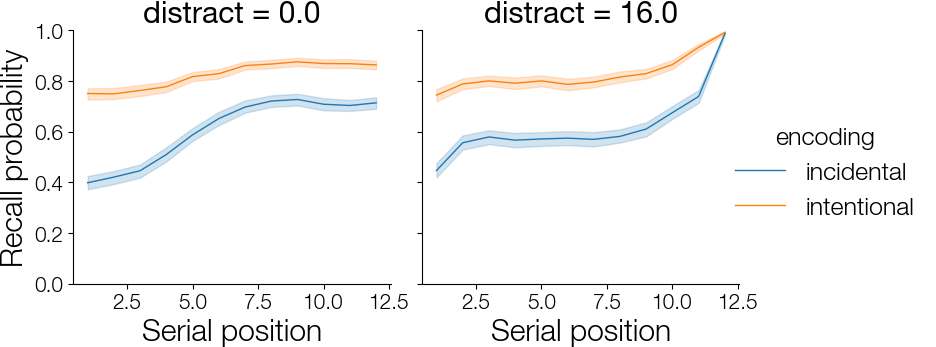

In [12]:
spc = sim_data.groupby(['distract', 'encoding']).apply(fr.spc)
fr.plot_spc(spc, col='distract', hue='encoding', height=4).add_legend()

/var/folders/4k/wss4rkc16j70t_mk8f3vf7300000gn/T/ipykernel_10447/1574759666.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spc = sim_data.groupby(['distract', 'encoding']).apply(fr.pnr).query('output == 1')


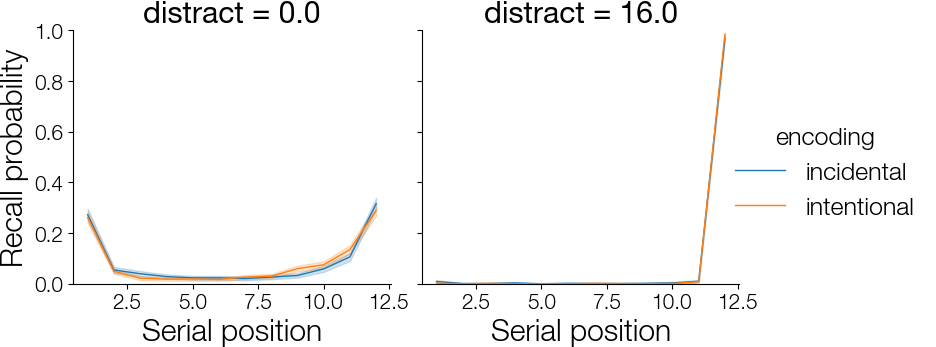

In [13]:
spc = sim_data.groupby(['distract', 'encoding']).apply(fr.pnr).query('output == 1')
fr.plot_spc(spc, col='distract', hue='encoding', height=4).add_legend()

/var/folders/4k/wss4rkc16j70t_mk8f3vf7300000gn/T/ipykernel_10447/612447598.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lag_crp = sim_data.groupby(['distract', 'encoding']).apply(fr.lag_crp)


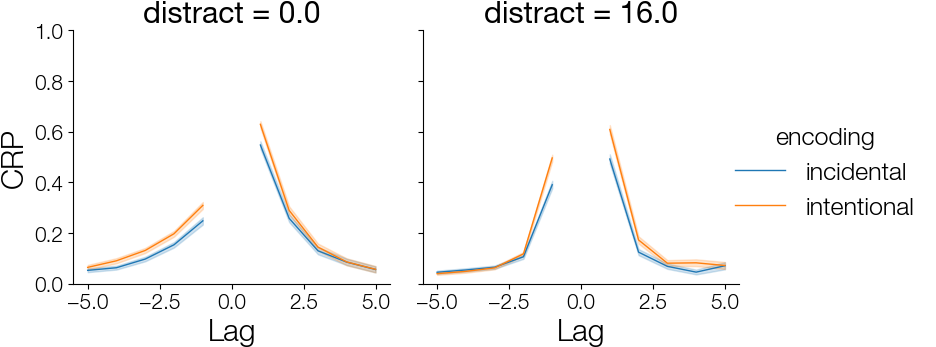

In [14]:
lag_crp = sim_data.groupby(['distract', 'encoding']).apply(fr.lag_crp)
fr.plot_lag_crp(lag_crp, col='distract', hue='encoding', height=4).add_legend()